### Importações 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from scipy.ndimage import convolve
import visualkeras
import os
import pathlib
import gradio as gr

### Data collection
We are using the mnist dataset for handwriting digits

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Convolution 

Uma convolução é um processo em que você realiza o produto entre duas funções, na programação podemos ver como sendo o produto entre dois arrays, ou matrizes, multi-dimensionais. Um exemplo de aplicação é a seguinte detecção de borda usando o "prewitt operator"

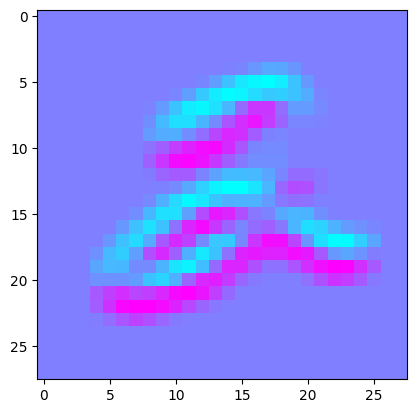

In [3]:
A = x_train[5]/255
K = [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]
convolved = convolve(A, K).reshape(28, 28) 
plt.imshow(convolved, cmap="cool")

2


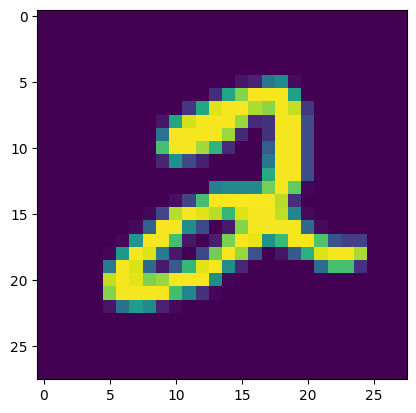

In [4]:

print(mnist.load_data()[0][1][5])
plt.imshow(mnist.load_data()[0][0][5])

### Data preparation

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0

### Neural network

A rede neural será composta pelas seguintes camadas:

- Camada de convolução com 50 neurônios onde cada um é um filtro 9x9
- Camada de MaxPooling para redução de dimensionalidade, com 50 neurônios
- Camada de convolução com 50 neurônios onde cada um é um filtro 5x5
- Camada de MaxPooling para redução de dimensionalidade, com 50 neurônios
- Uma camada densa de 128 neurônios com ativação relu
- Uma camada densa de 64 neurônios com ativação relu
- Uma camada densa de 10 neurônios com ativação leaky_relu

In [6]:
model = keras.Sequential([
        keras.layers.Conv2D(50, (9, 9), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(50, (5, 5), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='leaky_relu'),
        keras.layers.Dense(1),
])

In [7]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error', 'mean_absolute_error', 'accuracy', Precision(name='precision'),
               	Recall(name='recall')])

In [8]:
if(not os.path.exists(pathlib.PurePath('./model/nn_model'))):
    model.fit(x_train, y_train, epochs=50, batch_size=256)
    model.save(pathlib.PurePath('./model/nn_model'))
else:
    model.load_weights(pathlib.PurePath('./model/nn_model')) 


In [9]:
mse, mae, _, _, _, _ = model.evaluate(x_test, y_test)
print('Test loss (mae):', mae)
print('Test mse:', mse)

313/313 [==============================] - 3s 7ms/step - loss: 0.0690 - mean_squared_error: 0.1333 - mean_absolute_error: 0.0690 - accuracy: 0.2106 - precision: 0.9994 - recall: 0.9991
Test loss (mae): 0.13332195580005646
Test mse: 0.06901330500841141


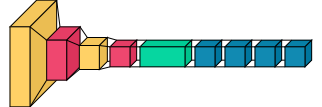

In [10]:
visualkeras.layered_view(model)

In [13]:
# Define the Gradio interface
def generate_binary_matrix(input_image):
    try:

        binary_matrix = input_image/255
        result = np.ravel(model.predict(binary_matrix.reshape(1, 28, 28), verbose=False))[0].round().astype(int)
        return str(result)
    except:
        return "Draw a single digit."

In [14]:
btn_correct = btn_wrong = btn_send = None
with gr.Blocks() as demo:
    with gr.Row() as row1:
        with gr.Column() as col1:
            sketchpad = gr.Sketchpad(shape=(28, 28), interactive=True)
        with gr.Column() as col2:
            text = gr.Text(label="Predicted number")
                
    sketchpad.change(fn=generate_binary_matrix, inputs=sketchpad, outputs=text)

    demo.queue().launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
